In [2]:
import numpy as np
import torch as th
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20, 20)   # figsize

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Shadow mask:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Face:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shading:  tensor(211, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shadow mask:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Face:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shading:  tensor(223, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shadow mask:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Face:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shading:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shadow mask:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Face:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Shading:  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


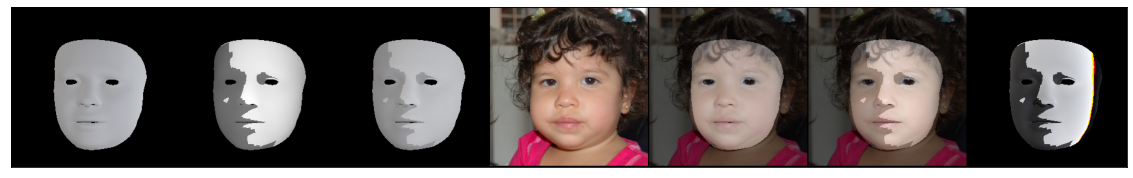

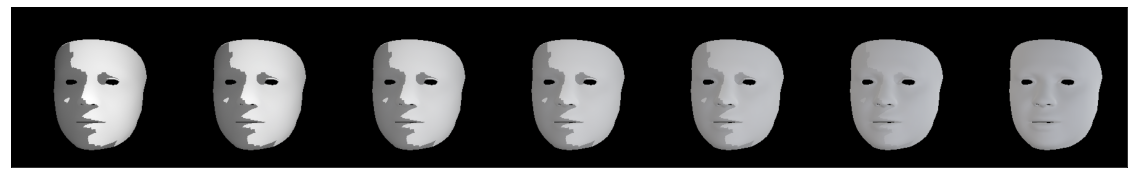

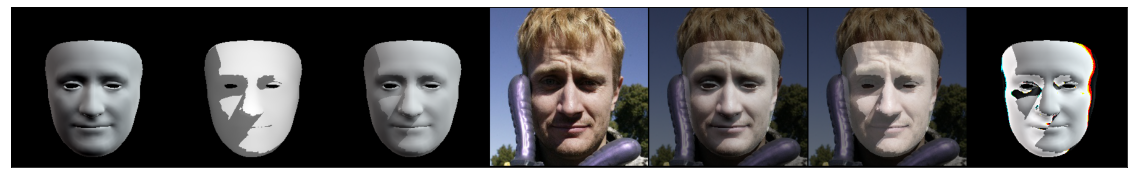

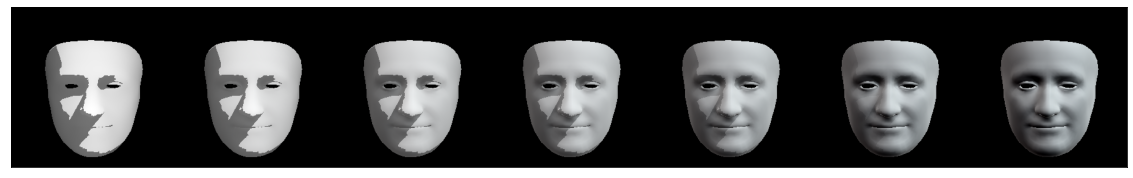

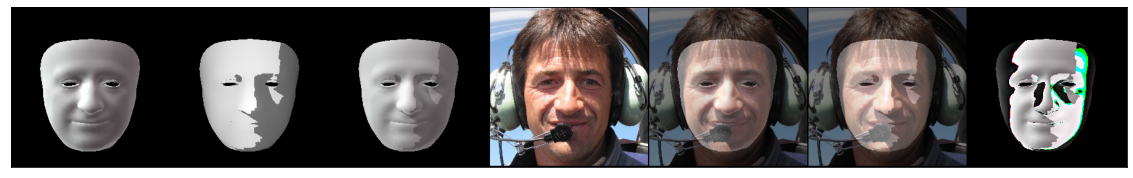

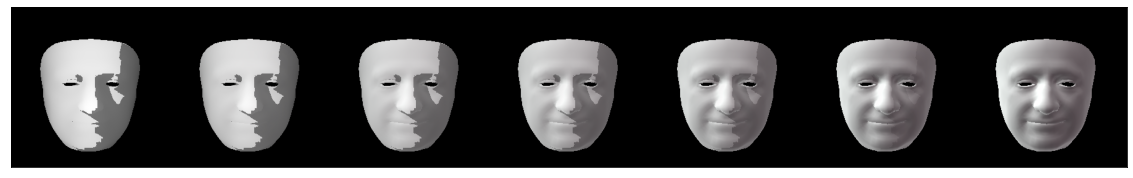

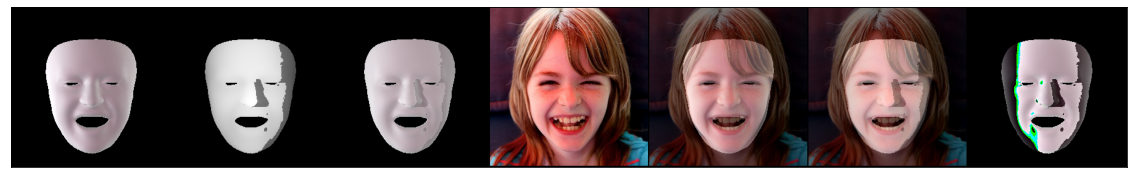

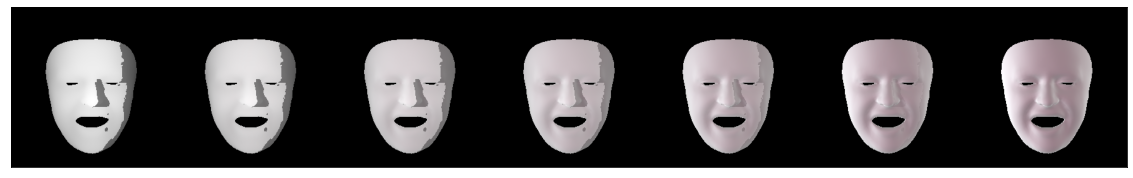

In [7]:
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'

def vis(img_id):
    # img_id = '60065'

    shadow_m = f'{data_path}/shadow_masks/{set_}/{img_id}.png'
    shadow_m_img = read_image(shadow_m)
    shadow_m_arr = np.array(shadow_m_img).transpose(1, 2, 0)
    print("Shadow mask: ", th.max(shadow_m_img), th.min(shadow_m_img))

    face = f'{data_path}/ffhq_256/{set_}/{img_id}.jpg'
    face_img = read_image(face)
    face_arr = np.array(face_img).transpose(1, 2, 0)
    print("Face: ", th.max(face_img), th.min(face_img))

    shading = f'{data_path}/rendered_images/deca_masked_face_images_wclip/{set_}/{img_id}.png'
    shading_img = read_image(shading)
    shading_arr = np.array(shading_img).transpose(1, 2, 0)
    print("Shading: ", th.max(shading_img), th.min(shading_img))

    # 
    ss = Image.blend(Image.fromarray(shading_arr), Image.fromarray(shadow_m_arr), alpha=0.3)
    shading_f = Image.blend(Image.fromarray(shading_arr), Image.fromarray(face_arr), alpha=0.5)
    shadows_f = Image.blend(Image.fromarray(shadow_m_arr), Image.fromarray(face_arr), alpha=0.5)


    grid = make_grid([shading_img, 
                    shadow_m_img, 
                    th.tensor(np.array(ss).transpose(2, 0, 1)),
                    face_img,
                    th.tensor(np.array(shading_f).transpose(2, 0, 1)),
                    th.tensor(np.array(shadows_f).transpose(2, 0, 1)),
                    shading_img - shadow_m_img,
                    ])
    show(grid)
    
    m0 = 0.0
    m1 = 0.1
    m2 = 0.3
    m3 = 0.5
    m4 = 0.7
    m5 = 0.9
    m6 = 1
    show(make_grid([
        # th.clip(shading_img * shadow_m_img, 0, 255),
        th.clip((shading_img/255.0 * m0) + ((1-m0) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m1) + ((1-m1) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m2) + ((1-m2) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m3) + ((1-m3) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m4) + ((1-m4) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m5) + ((1-m5) * shadow_m_img/255.0), 0, 1),
        th.clip((shading_img/255.0 * m6) + ((1-m6) * shadow_m_img/255.0), 0, 1),
    ]))
    
    return shadow_m_img, face_img, shading_img

for i in [60000, 60065, 60182, 65535]:
    shadow_m_img, face_img, shading_img = vis(i)


# Shadow Manipulation

In [ ]:
# Dataset
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'


# Sampling
reshadow_path = '/data/mint/sampling/Generated_reshadow_mintomax/log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml_steps250/ema_085000/valid/shadow/reverse_sampling/'
img_id = '60006'
n_frames = 20

shadow_m_img, face_img, shading_img = vis(int(img_id))

face = f'{data_path}/ffhq_256/{set_}/{img_id}.jpg'
face_img = read_image(face)
face_arr = np.array(face_img).transpose(1, 2, 0)
print("Face: ", th.max(face_img), th.min(face_img))

reshadow_img = [read_image(f'{reshadow_path}/src={img_id}.jpg/dst=60000.jpg/Lerp_1000/n_frames={n_frames}/res_frame{f}.png') for f in range(n_frames)]
print("Reshadow: ", th.max(reshadow_img[1]), th.min(reshadow_img[1]))

show(make_grid([reshadow_img[0], 
                reshadow_img[1],
                face_img,
                reshadow_img[-1],
            ]))
x = (th.abs(face_img - reshadow_img[1]))
print(th.max(x), th.min(x))
x = (th.abs(face_img - reshadow_img[1])) < 60
print(th.max(x), th.min(x))

show(make_grid([
                face_img - reshadow_img[0],
                face_img - reshadow_img[1],
                th.abs(face_img - reshadow_img[1]),
                th.tensor(((th.abs(face_img - reshadow_img[1]) > 60) * 255).cpu().numpy().astype(np.uint8)),
                face_img - face_img,
                face_img - reshadow_img[-1],
                ]))

# Gray-scale
face_gray = th.tensor(np.array(Image.fromarray(face_arr).convert('L')))
reshadow_gray = [th.tensor(np.array(Image.fromarray(np.array(img).transpose(1, 2, 0)).convert('L'))) for img in reshadow_img]
print(np.array(face_gray).shape)
print(np.array(reshadow_gray[1]).shape)

print(shadow_m_img.shape)
x = (face_gray - reshadow_gray[1])[None, ...]
print(th.max(x), th.min(x))
x = (face_gray - reshadow_gray[1])[None, ...] * shadow_m_img[0:1, ...]
print(th.max(x), th.min(x))
print(th.max(shadow_m_img), th.min(shadow_m_img), th.unique(shadow_m_img))

show(make_grid([
    shadow_m_img[0:1, ...],
    shadow_m_img[0:1, ...] == 0,
    shadow_m_img[0:1, ...] != 0,
]))

show(make_grid([
    face_gray[None, ...],
    reshadow_gray[1][None, ...],
    (face_gray - reshadow_gray[1])[None, ...],
    (face_gray - reshadow_gray[1])[None, ...] * (shadow_m_img[0:1, ...] != 0),
    (face_gray - reshadow_gray[1])[None, ...] * (shadow_m_img[0:1, ...] == 0),
]))
